<a href="https://colab.research.google.com/github/11lll/NLP_Disaster_Tweets/blob/main/NLP_Disaster_Tweets_(cleaned_L_12_H_768_A_12).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Albert

### Cean data: 

> After carefully examining the training dataset, it is seen that there are multiple records having same text and for some of these texts there are contradicting predicitons.Thus we would analyze this and remove duplicate records along with outliers.



- remove duplicates 
- remove outliersoutliers

Source: https://www.kaggle.com/pratiyushmishra/nlp-eda-cleaning-lstm-and-simplified-bert

In [1]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 6.1MB/s 
     |████████████████████████████████| 1.1MB 6.0MB/s 
     |████████████████████████████████| 706kB 36.4MB/s 
     |████████████████████████████████| 174kB 37.3MB/s 
     |████████████████████████████████| 358kB 30.0MB/s 
     |████████████████████████████████| 645kB 34.2MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 1.2MB 40.0MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import pandas as pd
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
import numpy as np

In [5]:
  df_test = pd.read_csv('/content/drive/MyDrive/kaggle_dataset/nlp_disaster_tweets/test.csv')
  df_train = pd.read_csv('/content/drive/MyDrive/kaggle_dataset/nlp_disaster_tweets/train.csv')

In [6]:

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Outliers & Duplicates

After carefully examining the training dataset, it is seen that there are multiple records having same text and for some of these texts there are contradicting predicitons.Thus we would analyze this and remove duplicate records along with outliers.

*source: https://www.kaggle.com/pratiyushmishra/nlp-eda-cleaning-lstm-and-simplified-bert*

In [7]:
duplicate_records = df_train[df_train.duplicated(['text','target'],keep=False)] # Duplicate records with same targets.
print('Records having same text and targets:',len(duplicate_records))
duplicate_records.head()

Records having same text and targets: 157


,id,keyword,location,text,target
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0


In [8]:
df_train.drop_duplicates(['text','target'],inplace=True) # Dropping the duplicate records having same targets.

In [9]:
contradicting_records = df_train[df_train.duplicated(['text'],keep=False)] # Duplicate records with outliers.
print('Records having same text but different targets:',len(contradicting_records))
contradicting_records.head()

Records having same text but different targets: 36


,id,keyword,location,text,target
610,881,bioterrorism,NaN,To fight bioterrorism sir.,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
1197,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1214,1752,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1221,1760,buildings%20burning,dallas,like for the music video I want some real acti...,1


In [10]:
#contradicting_records.to_csv(r'/content/drive/MyDrive/kaggle_dataset/nlp_disaster_tweets/disaster_tweets_contradictory_items.csv', index = False)

In [11]:
contradicting_records_to_drop = contradicting_records[contradicting_records.target != 0]
#contradicting_records_to_drop.head()


In [12]:
contra_rec_list = contradicting_records_to_drop['id'].tolist()
print(contra_rec_list)
df_train = df_train[~df_train['id'].isin(contra_rec_list)]

[881, 1723, 1760, 1968, 4068, 4659, 5662, 5996, 6012, 6097, 6112, 6123, 6134, 6223, 6537, 8018, 8698, 9472]


In [13]:
batch_size=25

train_ds = tf.data.Dataset.from_tensor_slices((df_train['text'].tolist(),df_train['target'].tolist())).batch(batch_size)

In [14]:
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [15]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [16]:
train_list = df_train["text"].tolist()
print(train_list[3])
target_list = df_train['target'].tolist()
print(target_list[:10])

13,000 people receive #wildfires evacuation orders in California 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
test_text = [train_list[3]]
text_preprocessed = bert_preprocess_model(test_text)
print(test_text)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

['13,000 people receive #wildfires evacuation orders in California ']
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2410  1010  2199  2111  4374  1001  3748 26332 13982  4449  1999]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [19]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-6.9772619e-01 -1.1846871e-01  9.5171922e-01 -2.6660612e-01
 -4.4178218e-05 -3.7698126e-01  2.3625235e-01  5.8289021e-01
 -2.9619947e-01  4.2820847e-01  4.3034378e-01  4.5014116e-01]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.31605     0.4988193  -0.2551651  ...  0.6606744   0.47547665
  -0.39449605]
 [ 0.48359233  1.5145749   0.53165615 ...  0.7285304   0.03800431
  -0.18383689]
 [-0.22511387  1.0732468  -0.06173173 ...  0.6683092  -0.11913485
  -0.08884874]
 ...
 [-0.28847992 -0.03675031 -0.12714313 ... -0.16364631  0.26412746
  -0.543529  ]
 [-0.37908727 -0.02641977  0.04326134 ...  0.13049668  0.19810605
  -0.52778006]
 [-0.22571787  0.5860365  -0.02010852 ... -0.5937169   0.40046874
  -0.021128  ]]


In [20]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [21]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(test_text))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.30441988]], shape=(1, 1), dtype=float32)


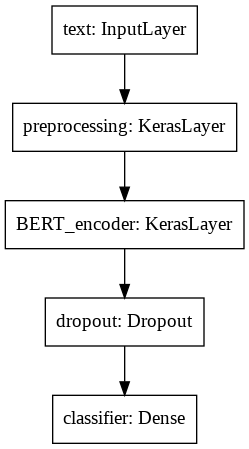

In [22]:
tf.keras.utils.plot_model(classifier_model)


In [23]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [24]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [25]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

### Adding class weights
The goal is to identify tweets about disasters, but we don't have as many positive samples as negative ones, so we would want to have the classifier heavily weight the few examples that are available. We can do this by passing weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

*Source: https://www.kaggle.com/pratiyushmishra/nlp-eda-cleaning-lstm-and-simplified-bert*

In [26]:
n_negative_training_examples = df_train.target.value_counts()[0]
n_positive_training_examples = df_train.target.value_counts()[1]
n_training_examples = len(df_train.index)

print("n_negative_training_examples:", n_negative_training_examples)
print("n_positive_training_examples:", n_positive_training_examples)
print("n_training_examples:", n_training_examples)

n_negative_training_examples: 4315
n_positive_training_examples: 3188
n_training_examples: 7503


In [27]:


# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / n_negative_training_examples)*(n_training_examples)/2.0 
weight_for_1 = (1 / n_positive_training_examples)*(n_training_examples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.87
Weight for class 1: 1.18


In [28]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Epoch 1/5
301/301 [==============================] - 404s 1s/step - loss: 0.6478 - binary_accuracy: 0.6743
Epoch 2/5
301/301 [==============================] - 386s 1s/step - loss: 0.4032 - binary_accuracy: 0.8254
Epoch 3/5
301/301 [==============================] - 385s 1s/step - loss: 0.2858 - binary_accuracy: 0.8883
Epoch 4/5
301/301 [==============================] - 386s 1s/step - loss: 0.1815 - binary_accuracy: 0.9278
Epoch 5/5
301/301 [==============================] - 387s 1s/step - loss: 0.1225 - binary_accuracy: 0.9563


dict_keys(['loss', 'binary_accuracy'])


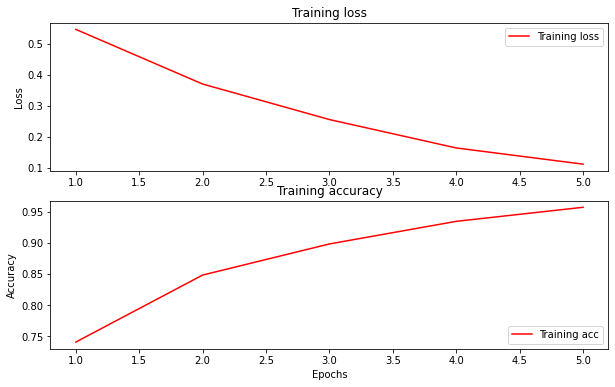

In [29]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.title('Training loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [30]:
probs = classifier_model.predict(df_test['text'])

print(probs)

[[6.057866 ]
 [8.919777 ]
 [8.995692 ]
 ...
 [8.4658375]
 [3.611704 ]
 [8.123525 ]]


In [31]:
threshold = 0

preds = np.where(probs[:,]>threshold, 1, 0)

In [32]:
print(preds)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [33]:
df_sub = df_test.drop(['keyword','location','text'], axis=1)
df_sub['target'] = preds
df_sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [34]:
df_sub.to_csv(r'/content/drive/MyDrive/kaggle_dataset/nlp_disaster_tweets/Dis_Tweets-L-12_H-768_A-12(5ep_20bat).csv', index = False)